# Survival Analysis for Loan Default

## Credit Risk models whether a borrower will fail to repay a loan supplied by a lender.

Financial institutions have traditionally developed models to quantify credit risk to limit exposure. Logistic regression, a binary outcome, has seen success traditionally in this context.
  
Time series analysis, specifically Survival Analyais, creates the possiblity of detirmining - not if something will happen - but when something will happen. Censoring occurs when the loan is under repayment at the moment of data gathering. The origin of all loans (the birth event) is known, but for some loans, a default has not yet occured (the death event). In these cases, it is uknown whether the borrower is good or bad. The customers who have not defaulted yet will be labelled “censored” in the analysis.
  
This project utilizes a dataset of 50,000 U.S. mortage borrowers, and is available for download [here](http://www.creditriskanalytics.net/datasets-private2.html).  

The data is assembled in panel form and represents borrowers over 60 periods. the loan may originate before the start of the observation period. The loan observations may thus be censored as the loans mature or borrowers refinance. The data set is a randomized selection of mortgage-loan-level data collected from the portfolios underlying U.S. residential mortgage-backed securities (RMBS) securitization portfolios.  

### Summary

##### Main Objective: 
##### Brief Dataset Overview:
##### Summary of Exploration/Feature Engineering:
##### Summary of Model Training:
##### Model Reccomendation:
##### Key Findings:
##### Next Steps: 

In [81]:
# Import necessary packages
import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import datetimes_to_durations 
from lifelines.utils import concordance_index

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import torch
import torch.optim as optim
from pycox.models import CoxPH
from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

import matplotlib.pyplot as plt
import seaborn as sns

*Data cleaning and checking*

In [8]:
# Read in dataset 
mortgage_df = pd.read_csv('mortgage.csv')

In [9]:
mortgage_df.head(3)

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0


Data Dictionary:
- id: Borrower ID
- time: Time stamp of observation
- orig_time: Time stamp for origination
- first_time: Time stamp for first observation
- mat_time: Time stamp for maturity
- balance_time: Outstanding balance at observation time
- LTV_time: Loan-to-value ratio at observation time, in %
- interest_rate_time: Interest rate at observation time, in %
- hpi_time: House price index at observation time, base year = 100
- gdp_time: Gross domestic product (GDP) growth at observation time, in %
- uer_time: Unemployment rate at observation time, in %
- REtype_CO_orig_time: Real estate type condominium = 1, otherwise = 0
- REtype_PU_orig_time: Real estate type planned urban development = 1, otherwise = 0
- REtype_SF_orig_time: Single-family home = 1, otherwise = 0
- investor_orig_time: Investor borrower = 1, otherwise = 0
- balance_orig_time: Outstanding balance at origination time
- FICO_orig_time: FICO score at origination time, in %
- LTV_orig_time: Loan-to-value ratio at origination time, in %
- Interest_Rate_orig_time: Interest rate at origination time, in %
- hpi_orig_time: House price index at origination time, base year = 100
- default_time: Default observation at observation time
- payoff_time: Payoff observation at observation time
- status_time: Default (1), payoff (2), and nondefault/nonpayoff (0) observation at observation time

In [10]:
# Preparing data for analysis

# In survival analysis, censoring can be either right-censoring or left-censoring. 
# In this case, the data have right-censoring since the loans may mature or borrowers may refinance before defaulting. 

# Create a new censoring column- resulting 'default_time' column will have values of 1 for uncensored observations 

# Group data by ID and aggregate values for each column
aggregated_data = mortgage_df.groupby('id', as_index=False).agg({
    'default_time': 'max',  # Max value represents whether the death event happened at observation
    'time': 'count',  # count the rows with the matching ID
    'hpi_time': 'last',  # House price index 
    'gdp_time': 'last',  # GDP growth 
    'uer_time': 'last',  # Unemployment rate 
    'REtype_PU_orig_time': 'last',  # Real estate type planned urban development 
    'balance_time': 'last'  # Outstanding balance 
})

# Rename columns to match the time series format
aggregated_data.columns = [
    'ID', 'default_time', 'total_obs_time', 'house_price_index_time',
    'gdp_time', 'unemployment_rate_time', 'real_estate_planned_urban_dev', 'balance_time'
]

# Print the aggregated data
aggregated_data.head(10)

,ID,default_time,total_obs_time,house_price_index_time,gdp_time,unemployment_rate_time,real_estate_planned_urban_dev,balance_time
0,1,1,24,146.45,2.715903,8.3,0,29087.21
1,2,0,2,225.10,2.151365,4.7,0,105654.77
2,3,0,5,217.37,1.692969,4.5,0,44378.60
3,4,0,35,189.82,2.836358,5.7,0,52686.35
4,5,0,3,222.39,2.361722,4.4,0,52100.71
5,6,1,31,181.43,1.717053,6.6,0,190474.11
6,7,0,2,225.10,2.151365,4.7,0,107916.38
7,8,0,1,226.29,2.899137,4.7,0,152393.21
8,9,1,13,153.35,-4.146711,9.0,0,130140.31
9,10,1,5,217.37,1.692969,4.5,0,88046.35


In [11]:
# Set the "ID" column as the index
aggregated_data.set_index('ID', inplace=True)

# Check for missing values in the entire dataset
missing_values = aggregated_data.isna().sum()

# Display the count of missing values for each column
print(missing_values)

default_time                     0
total_obs_time                   0
house_price_index_time           0
gdp_time                         0
unemployment_rate_time           0
real_estate_planned_urban_dev    0
balance_time                     0
dtype: int64


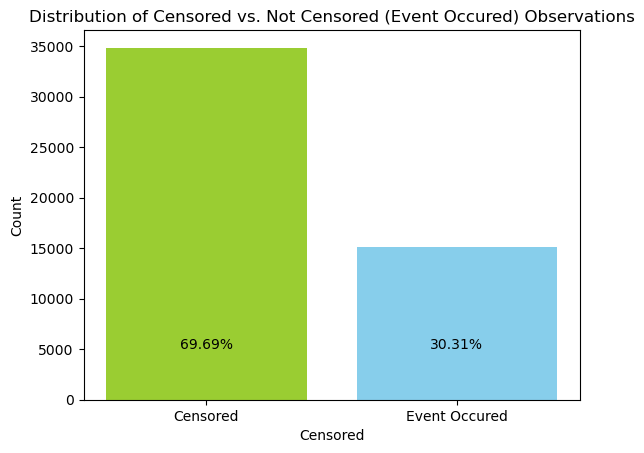

In [12]:
# Visualize distribution of censored vs uncensored events

censored_counts = aggregated_data['default_time'].value_counts()

total_samples = len(aggregated_data)

# Calculate percentages
censored_percentages = (censored_counts / total_samples) * 100

# Set up bar colors
colors = ['yellowgreen', 'skyblue']

plt.bar(censored_counts.index, censored_counts.values, color=colors)
plt.xlabel('Censored')
plt.ylabel('Count')
plt.xticks([0, 1], ['Censored', 'Event Occured'])
plt.title('Distribution of Censored vs. Not Censored (Event Occured) Observations')

# Add percentages as text above each bar
for i, count in enumerate(censored_counts):
    plt.text(i, 5000, f'{censored_percentages[i]:.2f}%', ha='center')

plt.show()

There is potential for class imbalance. Two-thirds of observatiosn are censored. However, removing these observations would significantly bias the outcome. Survival analysis allows for these key pieces of information to be factored into the model. 

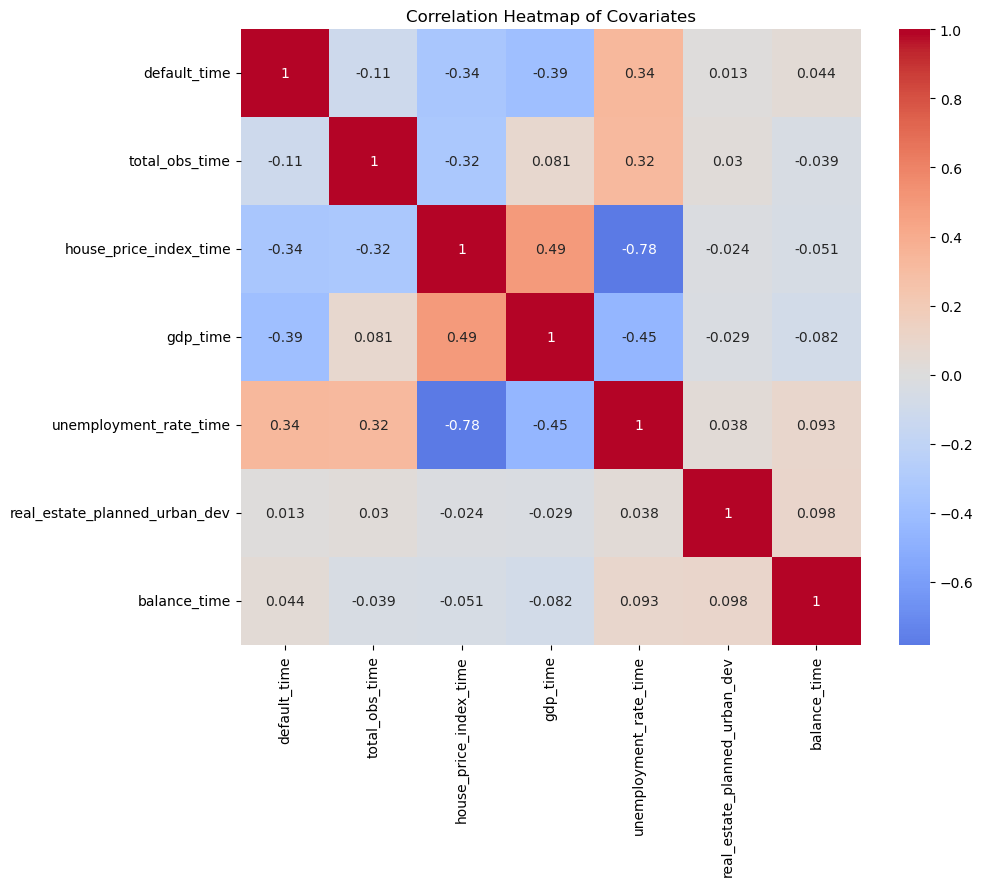

In [13]:
# Checking for potential multicollinearity

# Generate the correlation matrix
correlation_matrix = aggregated_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Covariates')
plt.show()

There is a known strong, negative relationship between the unemployment rate and housing prices. This relationship is noted and expanded on in literature, e.g. [St. Louis Fed](https://research.stlouisfed.org/publications/employment-research/is-local-unemployment-related-to-local-housing-prices). A regression model with regularization (Lasso/Ridge) will be employed and tested to manage potential impact. 

##### Kaplan-Meier Estimator
  
The Kaplan-Meier Curve represents a simple non-parametric visualization of survival likelihood function in the data.    

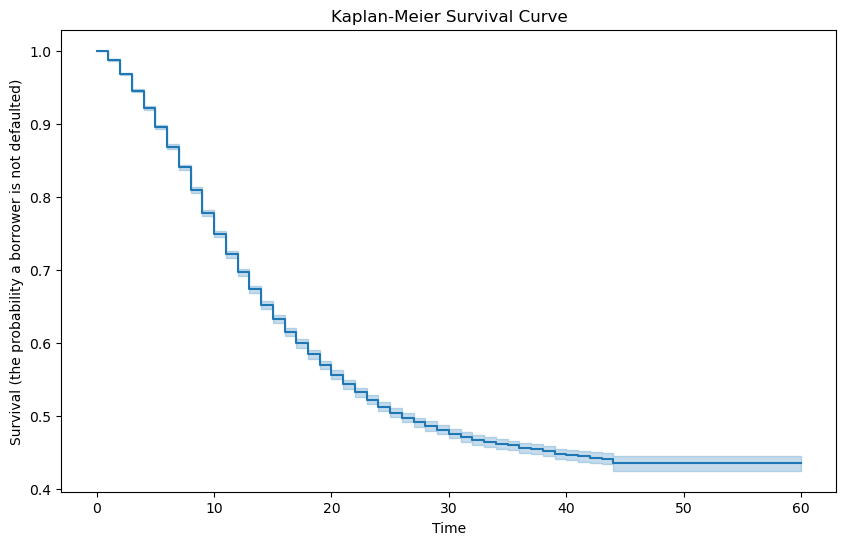

In [14]:
# Create a Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator using the 'default_time' and 'total_obs_time' columns
kmf.fit(aggregated_data['total_obs_time'], event_observed=aggregated_data['default_time'])

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot(legend=None)
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival (the probability a borrower is not defaulted)')
plt.show()

In [15]:
# Estimate the survival probability at month 12
time_to_estimate = 12
survival_probability = kmf.predict(time_to_estimate)
print(f"Survival probability at time {time_to_estimate}: {survival_probability:.4f}")

Survival probability at time 12: 0.6966


There is no need to split the data for the KMF curve since all observations, both censored and defaulted, are used in estimation. The observations have the same survival probabilty regardless of the time of the appearence in the loan snapshot data. This shows no individual estimations but the overall population survival distribution.
   
*The probability that any given mortgage borrower is not in default after one year is 69.66%*

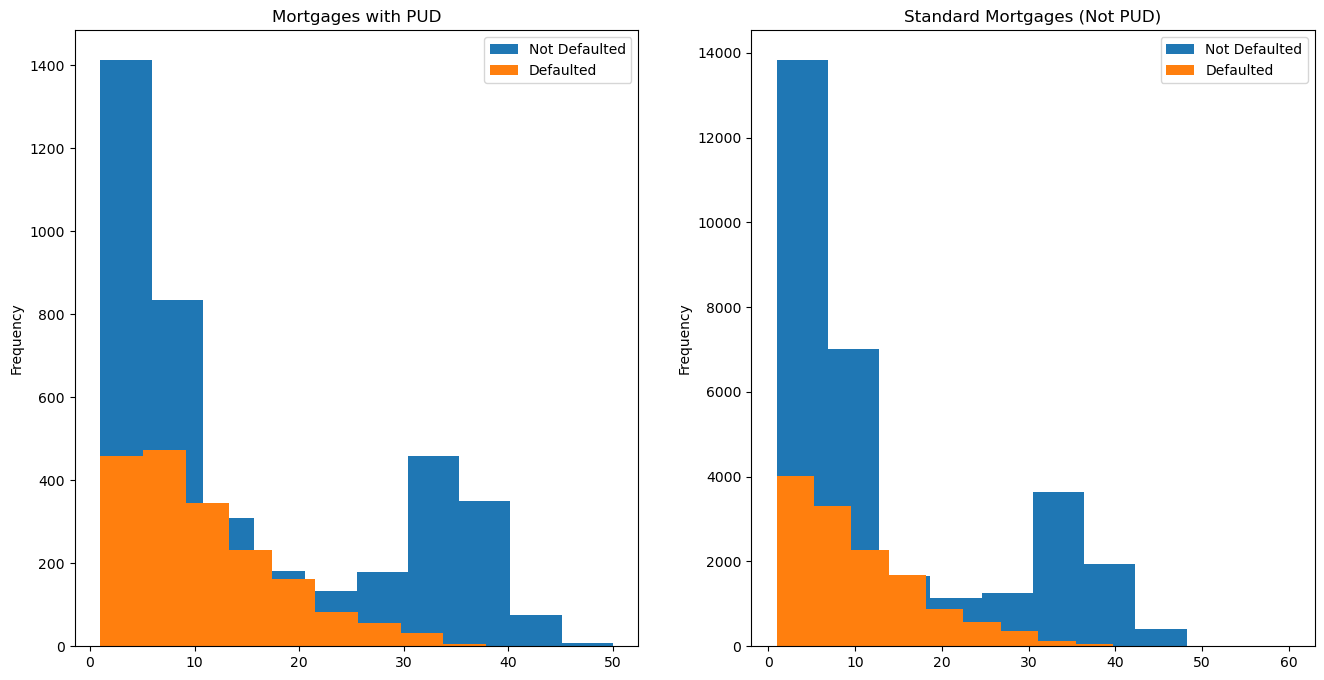

In [16]:
# Probability by real estate type planned urban development (PUD)
# planned urban development refers to a real estate development that integrates residential 
# and commercial buildings with open spaces in a single project.

# Checking the difference in PUD
aggregated_data1 = aggregated_data[aggregated_data.real_estate_planned_urban_dev==1]
aggregated_data0 = aggregated_data[aggregated_data.real_estate_planned_urban_dev==0]

fig, ax = plt.subplots(1,2, figsize=(16,8))
aggregated_data1.groupby('default_time')['total_obs_time'].plot(kind='hist', ax=ax[0], title='Mortgages with PUD')
ax[0].legend(labels=['Not Defaulted', 'Defaulted'])
aggregated_data0.groupby('default_time')['total_obs_time'].plot(kind='hist', ax=ax[1], title='Standard Mortgages (Not PUD)')
ax[1].legend(labels=['Not Defaulted', 'Defaulted'])

Text(0, 0.5, 'Survival probability')

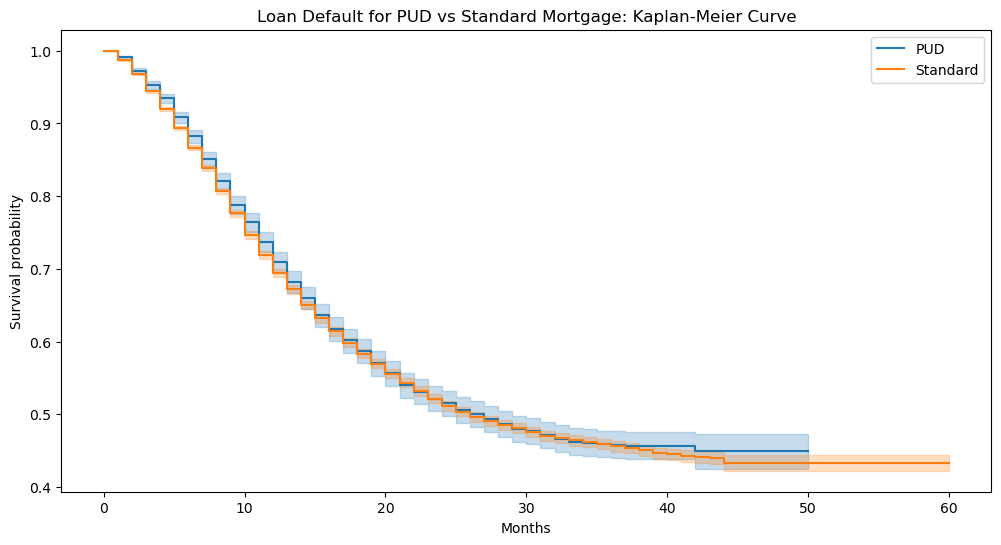

In [17]:
kmf.fit(aggregated_data1.total_obs_time, aggregated_data1.default_time)
kmf.plot(label='PUD', figsize=(12, 6))
kmf.fit(aggregated_data0.total_obs_time, aggregated_data0.default_time)
kmf.plot(label='Standard')
plt.title('Loan Default for PUD vs Standard Mortgage: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

The difference among planned urban development (real estate development that integrates residential and commercial buildings with open spaces in a single project) and standard mortgages varies only slightly. 

##### Cox Proportional Hazard 

CoxPH model includes time, censorship, and covariates to generate multivariate survival statistics. It describes relationships between survival distribution and covariates. This mdoel is semi-parametric because it contains a set of covariates and a baseline hazard (the value of hazard when all covariates are equal to zero). The hazard ratio is the effect of the observerd covariates on the baseline. 

In [18]:
# First, need to dummy code the binary variable for PUD to align with model specifications
dummy_pud = pd.get_dummies(aggregated_data['real_estate_planned_urban_dev'], prefix='PUD')

# concatinate to the dataset
dummies_pud = dummy_pud[['PUD_0', 'PUD_1']]

# set axis to 1 to make new columns
aggregated_data_w_dummy = pd.concat([aggregated_data, dummies_pud], axis = 1)

# drop the old planned_urban_development column 
aggregated_data_w_dummy.drop(columns=['real_estate_planned_urban_dev'], inplace=True)

aggregated_data_w_dummy.head(4)

,default_time,total_obs_time,house_price_index_time,gdp_time,unemployment_rate_time,balance_time,PUD_0,PUD_1
ID,,,,,,,,
1,1,24,146.45,2.715903,8.3,29087.21,1,0
2,0,2,225.10,2.151365,4.7,105654.77,1,0
3,0,5,217.37,1.692969,4.5,44378.60,1,0
4,0,35,189.82,2.836358,5.7,52686.35,1,0


In [19]:
# Fitting Cox Proportional Model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(aggregated_data_w_dummy, duration_col='total_obs_time', event_col='default_time')
cph.print_summary(decimals =4, style='ascii')

<lifelines.CoxPHFitter: fitted with 50000 total observations, 34846 right-censored observations>
             duration col = 'total_obs_time'
                event col = 'default_time'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 50000
number of events observed = 15154
   partial log-likelihood = -149596.8400
         time fit was run = 2023-09-06 20:33:24 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
house_price_index_time  0.0000     1.0000     0.0004          -0.0008           0.0008               0.9992               1.0008
gdp_time               -0.2160     0.8057     0.0035          -0.2230          -0.2091               0.8002               0.8113
unemployment_rate_time -0.0476   

The CoxPH results suggest the proportionality assumption needs to be checked and multicolinearity is impacting the model. A key assumption of the model is that for any two subjects stay proportional at any point in time and the hazard ratio does not vary with time.  

Plotting the log-log survival curves for different individuals should be roughly parallel to each other over time. This suggests that the hazard ratios of individuals are approximately constant over time. The curves should not diverge over time or criss cross over time. 
  

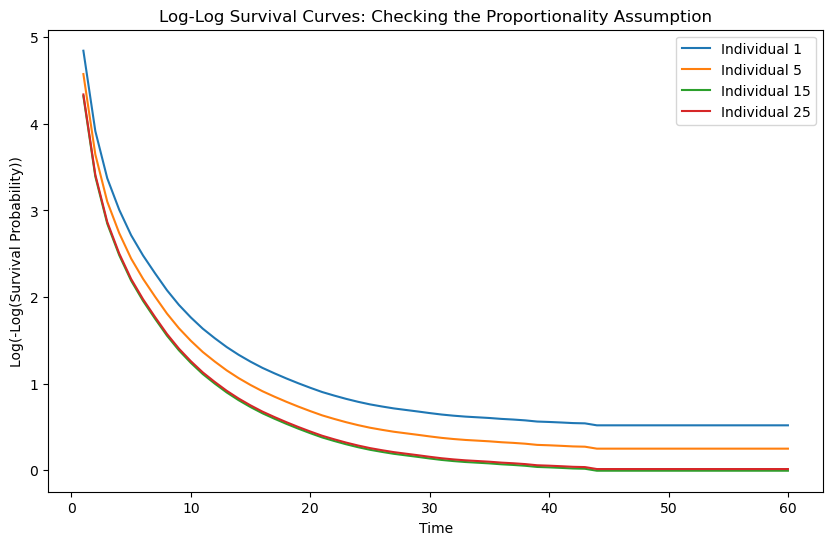

In [20]:
# Calculate the predicted log-log survival curves for specific individuals
individuals_to_plot = [1, 5, 15, 25] # psuedo randomly selected
individual_data = aggregated_data_w_dummy[aggregated_data_w_dummy.index.isin(individuals_to_plot)]
predicted_survival_curves = cph.predict_survival_function(individual_data)

# Plot the log-log survival curves
plt.figure(figsize=(10, 6))
for ind in individuals_to_plot:
    individual_curve = cph.predict_survival_function(individual_data.loc[[ind]])
    plt.plot(individual_curve.index, -np.log(-np.log(individual_curve.values)), label=f'Individual {ind}') # take the log using numpy

plt.title('Log-Log Survival Curves: Checking the Proportionality Assumption')
plt.xlabel('Time')
plt.ylabel('Log(-Log(Survival Probability))')
plt.legend()
plt.show()

The CoxPH model does not fit this data well since the data contains mortgages where any two subjects are not necesssarily proportional at any point in time, thereby violating a key assumption.  The plot observes divergence in the log-log survival curves moving away from time 0, suggesting that the proportional hazards assumption may be violated as well as some criss-crossing, meaning that the effect of covariates is not constant.  

##### Traditional Machine Learning Predicition

Random survival forest constructs an ensemble estimate for a cumulative hazard function. The approach uses log-rank test to split and then calculates the cumulutive hazards of the nodes in each tree and finds the average. 

In [21]:
# package requires boolean data type rather than 0 | 1
aggregated_data_ml = aggregated_data.copy()
aggregated_data_ml['default_time'] = aggregated_data_ml['default_time'].astype(bool)

# Define the target variable as a structured array of (event, time)
y = aggregated_data_ml[['default_time', 'total_obs_time']].to_records(index=False)

# Define the feature matrix
X = aggregated_data_ml.drop(columns=['default_time', 'total_obs_time'])

# Split the data into training and testing sets
# 80 // 20 split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Survival Forest model
rsf = RandomSurvivalForest()

rsf.fit(X_train, y_train)

# Predict survival probabilities for the test set
y_pred_out = rsf.predict(X_test)

In [22]:
# Calculate the concordance index (C-index) for the model
c_index = concordance_index_censored(y_test['default_time'], y_test['total_obs_time'], y_pred_out)

In [23]:
# Access the C-index from the tuple
c_index_value = c_index[0]

# Print the C-index value with the desired format
print(f"Concordance Index (C-index): {c_index_value:.4f}")

Concordance Index (C-index): 0.6950


The C-index is a value between 0 and 1, where 0 indicates a completely inaccurate model (no predictive power), and 1 indicates a perfect model (perfectly predicts the relative risks of all individuals). 0.5 would suggest the model performs no better than random chance (no predictive power). Concordance refers to the ability to correctly provide a ranking of survival times based on the individual risk scores- a subject that dies at time t should have a higher risk at time t than a subject who survives beyond time t.

0.6950 is moderately predictive. 

##### Deep Learning Prediction

First attempt: use Keras (TensorFlow) to train a deep learning model to predict time and events

In [60]:
# Re split the data, but now into training, testing, and validation

# Define the target variable as a structured array of (event, time)
y = aggregated_data_ml[['default_time', 'total_obs_time']].to_numpy()

# Define the feature matrix
X = aggregated_data_ml.drop(columns=['default_time', 'total_obs_time']).to_numpy()

# Convert y to appropriate data types
y_event = y[:, 0].astype(bool)
y_time = y[:, 1].astype(np.float32)

# Split the data into training and validation sets
X_train, X_val, y_train_event, y_val_event, y_train_time, y_val_time = train_test_split(
    X, y_event, y_time, test_size=0.2, random_state=42
)

In [62]:
# Define the first model for time prediction
model_time = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Output layer for time prediction
])

# Compile the model for time prediction
model_time.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model for time prediction
history_time = model_time.fit(
    X_train,
    y_train_time,
    epochs=100,
    validation_data=(X_val, y_val_time)
)

# Define the second model for event prediction
model_event = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for event prediction
])

# Compile the model for event prediction
model_event.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for event prediction
history_event = model_event.fit(
    X_train,
    y_train_event,
    epochs=100,
    validation_data=(X_val, y_val_event)
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 1s 30us/sample - loss: 1628490.7628 - acc: 0.0634 - val_loss: 9637.4976 - val_acc: 0.0754
Epoch 2/100
40000/40000 [==============================] - 1s 25us/sample - loss: 2145497.2504 - acc: 0.0510 - val_loss: 148.5203 - val_acc: 0.0754
Epoch 3/100
40000/40000 [==============================] - 1s 29us/sample - loss: 4965.6515 - acc: 0.0670 - val_loss: 259.0922 - val_acc: 0.0754
Epoch 4/100
40000/40000 [==============================] - 2s 43us/sample - loss: 175721.2513 - acc: 0.0623 - val_loss: 283.9639 - val_acc: 0.0582
Epoch 5/100
40000/40000 [==============================] - 2s 45us/sample - loss: 262574.0074 - acc: 0.0541 - val_loss: 121366.1116 - val_acc: 0.0754
Epoch 6/100
40000/40000 [==============================] - 2s 45us/sample - loss: 1318020.4286 - acc: 0.0545 - val_loss: 357.8345 - val_acc: 0.0754
Epoch 7/100
40000/40000 [==============================] - 2s 5

Epoch 57/100
40000/40000 [==============================] - 2s 43us/sample - loss: 133.6479 - acc: 0.0755 - val_loss: 135.7478 - val_acc: 0.0754
Epoch 58/100
40000/40000 [==============================] - 2s 41us/sample - loss: 133.5222 - acc: 0.0755 - val_loss: 135.9806 - val_acc: 0.0754
Epoch 59/100
40000/40000 [==============================] - 2s 40us/sample - loss: 133.2804 - acc: 0.0755 - val_loss: 135.8771 - val_acc: 0.0754
Epoch 60/100
40000/40000 [==============================] - 2s 51us/sample - loss: 133.5383 - acc: 0.0755 - val_loss: 136.0133 - val_acc: 0.0754
Epoch 61/100
40000/40000 [==============================] - 2s 58us/sample - loss: 133.5553 - acc: 0.0755 - val_loss: 136.1051 - val_acc: 0.0754
Epoch 62/100
40000/40000 [==============================] - 2s 49us/sample - loss: 133.6325 - acc: 0.0755 - val_loss: 136.4278 - val_acc: 0.0754
Epoch 63/100
40000/40000 [==============================] - 2s 40us/sample - loss: 133.6766 - acc: 0.0755 - val_loss: 135.7954 - v

40000/40000 [==============================] - 2s 62us/sample - loss: 3.8765 - acc: 0.6176 - val_loss: 8.0605 - val_acc: 0.6986
Epoch 14/100
40000/40000 [==============================] - 2s 55us/sample - loss: 2.3268 - acc: 0.6334 - val_loss: 2.0488 - val_acc: 0.3845
Epoch 15/100
40000/40000 [==============================] - 2s 43us/sample - loss: 1.1109 - acc: 0.6645 - val_loss: 0.6476 - val_acc: 0.7080
Epoch 16/100
40000/40000 [==============================] - 2s 41us/sample - loss: 0.7937 - acc: 0.6766 - val_loss: 0.5679 - val_acc: 0.7134
Epoch 17/100
40000/40000 [==============================] - 2s 44us/sample - loss: 0.6644 - acc: 0.5810 - val_loss: 0.6466 - val_acc: 0.6989
Epoch 18/100
40000/40000 [==============================] - 2s 45us/sample - loss: 0.6197 - acc: 0.6964 - val_loss: 0.6080 - val_acc: 0.6989
Epoch 19/100
40000/40000 [==============================] - 2s 46us/sample - loss: 0.6085 - acc: 0.6963 - val_loss: 0.5987 - val_acc: 0.6989
Epoch 20/100
40000/40000 [

40000/40000 [==============================] - 2s 56us/sample - loss: 0.6103 - acc: 0.6964 - val_loss: 0.6082 - val_acc: 0.6989
Epoch 72/100
40000/40000 [==============================] - 2s 56us/sample - loss: 0.6103 - acc: 0.6964 - val_loss: 0.6082 - val_acc: 0.6989
Epoch 73/100
40000/40000 [==============================] - 3s 67us/sample - loss: 0.6102 - acc: 0.6964 - val_loss: 0.6081 - val_acc: 0.6989
Epoch 74/100
40000/40000 [==============================] - 3s 68us/sample - loss: 0.6103 - acc: 0.6964 - val_loss: 0.6081 - val_acc: 0.6989
Epoch 75/100
40000/40000 [==============================] - 3s 63us/sample - loss: 0.6102 - acc: 0.6964 - val_loss: 0.6080 - val_acc: 0.6989
Epoch 76/100
40000/40000 [==============================] - 2s 54us/sample - loss: 0.6337 - acc: 0.6964 - val_loss: 0.6082 - val_acc: 0.6989
Epoch 77/100
40000/40000 [==============================] - 2s 55us/sample - loss: 0.6107 - acc: 0.6963 - val_loss: 0.6083 - val_acc: 0.6989
Epoch 78/100
40000/40000 [

Second attempt: Using DeepSurv

Credit for DeepSurv at [Jared Katzman's GitHub](https://github.com/jaredleekatzman/DeepSurv)  

Academic paper excerpt:  
"*Standard survival models like the linear Cox proportional hazards model require extensive feature engineering or prior medical knowledge to model treatment interaction at an individual level. While nonlinear survival methods, such as neural networks and survival forests, can inherently model these high-level interaction terms, they have yet to be shown as effective treatment recommender systems. We introduce DeepSurv, a Cox proportional hazards deep neural network and state-of-the-art survival method for modeling interactions between a patient's covariates and treatment effectiveness in order to provide personalized treatment recommendations.*"

In [88]:
# Prepare Data for Pycox

aggregated_data_dl = aggregated_data.copy()

# Define the duration (time to event or censoring) and event (binary indicator) columns
duration_col = 'total_obs_time'
event_col = 'default_time'

